# PREDICTING SURVIVAL ON TITANIC

In [1]:
# importing main libraries
import numpy as np
import pandas as pd

In [2]:
# importing libraries for visuaisation
import seaborn as sn
from matplotlib import pyplot as plt
from matplotlib import style as st

In [3]:
# Using RandomForestClassifier as algorithm
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Importing test data in the notebook
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_fc7d5c0d10b7469a954488fb39bd6d63 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='-N5jUojhx8Q9ut2YNFfTClnwu_jhTPGarkAzO0GmS-yu',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_fc7d5c0d10b7469a954488fb39bd6d63.get_object(Bucket='predictingsurvivorsoftitanic-donotdelete-pr-h5yarwha7n5wzr',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_data = pd.read_csv(body)



In [5]:
#importing train data 

body = client_fc7d5c0d10b7469a954488fb39bd6d63.get_object(Bucket='predictingsurvivorsoftitanic-donotdelete-pr-h5yarwha7n5wzr',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train_data = pd.read_csv(body)



In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Using the describe above we understand that age has missing values.Also approximately 38% people in training set survived.

In [8]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [9]:
# First we give values to all missing and NAN values. For that we count the number of null values in the columns and make a new dataframe named missing
total = train_data.isnull().sum().sort_values(ascending= False)
percent_1 = (train_data.isnull().sum()/ train_data.isnull().count())*100  # count the columns which has null in it.
percent_2 = (round(percent_1,1).sort_values(ascending = False))
missing=  pd.concat([total,percent_2], axis = 1, keys = ['total','%'])
missing.head(5)

,total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


We see from above table that Cabin has 687 mising values. Embarked has two while age has 177.

Now we check the correlation between attributes to check what attributes can be used to make model.

Text(0.5, 1.0, 'MALE')

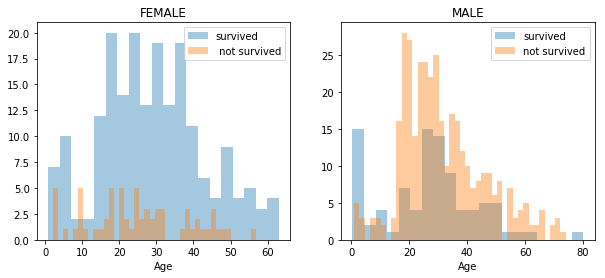

In [10]:
# AGE AND SEX CORRELATION ON SURVIVAL

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4)) #To make multiple graph axis and to tell where should these graph be placed.
female = train_data[train_data['Sex'] == 'female']
male = train_data[train_data['Sex'] == 'male']
# making a kernel density estimation graph for women who survived and women who did not with respect to age.
ax = sn.distplot(female[female['Survived'] == 1].Age.dropna(), bins = 20 , label = 'survived', ax = axes[0], kde = False)
ax = sn.distplot(female[female['Survived'] == 0].Age.dropna() , bins = 40 , label =' not survived' ,  ax = axes[0] , kde = False)
ax.legend()  # adding the box representative
ax.set_title('FEMALE')
# making a kernel density estimation graph for men who survived and women who did not with respect to age.
ax = sn.distplot(male[male['Survived'] == 1].Age.dropna(), bins = 20 , label ='survived', ax =axes[1] ,kde = False)
ax = sn.distplot(male[male['Survived'] == 0].Age.dropna(), bins = 40 ,label ='not survived', ax = axes[1],kde =False)
ax.legend()
ax.set_title("MALE")


In [11]:
pl =  female[female['Survived'] == 1].Age.dropna()
pl.describe()

count    197.000000
mean      28.847716
std       14.175073
min        0.750000
25%       19.000000
50%       28.000000
75%       38.000000
max       63.000000
Name: Age, dtype: float64

In [12]:
pl1 = female[female['Survived'] == 0].Age.dropna()
pl1.describe()


count    64.000000
mean     25.046875
std      13.618591
min       2.000000
25%      16.750000
50%      24.500000
75%      33.250000
max      57.000000
Name: Age, dtype: float64

Now we will check the importance of the port of embarkment and pclass for survival.

Text(0.5, 1.0, 'Class C')

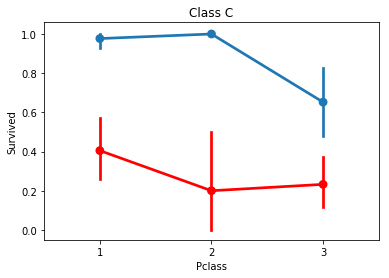

In [13]:
# We are using point plot to check. This is for port C
em = sn.pointplot(x = 'Pclass',y = 'Survived', data =  female[female['Embarked']== 'C'],palette=None,  order=None, hue_order=None)
em = sn.pointplot(x = 'Pclass',y = 'Survived', data =  male[male['Embarked']== 'C'],palette=None,  order=None, hue_order=None, color = 'r')
em.set_title("Class C")

Text(0.5, 1.0, 'Class S')

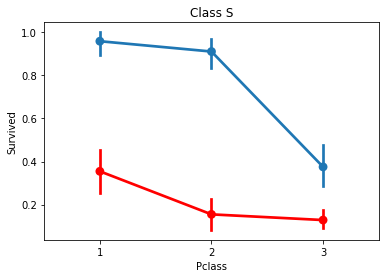

In [14]:
# this is for port S
em = sn.pointplot(x = 'Pclass',y = 'Survived', data =  female[female['Embarked']== 'S'],palette=None,  order=None, hue_order=None)
em = sn.pointplot(x = 'Pclass',y = 'Survived', data =  male[male['Embarked']== 'S'],palette=None,  order=None, hue_order=None, color = 'r')
em.set_title("Class S")

Text(0.5, 1.0, 'Class Q')

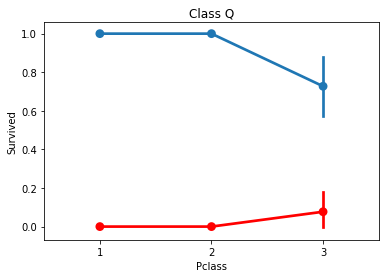

In [15]:
# This is for port Q
em = sn.pointplot(x = 'Pclass',y = 'Survived', data = female[female['Embarked']== 'Q'],palette=None,  order=None, hue_order=None)
em = sn.pointplot(x = 'Pclass',y = 'Survived', data = male[male['Embarked']== 'Q'],palette=None,  order=None, hue_order=None, color = 'r')
em.set_title("Class Q")

Survival of Women is greater than men.

Pclass versus Survival.

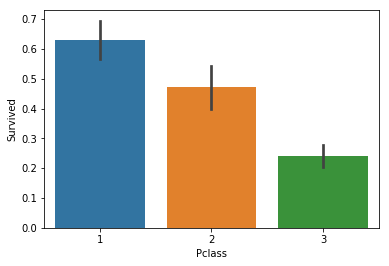

In [16]:
sn.barplot(x='Pclass', y='Survived', data=train_data)

People in Pclass 1 has more survival rate then in Pclass 3.

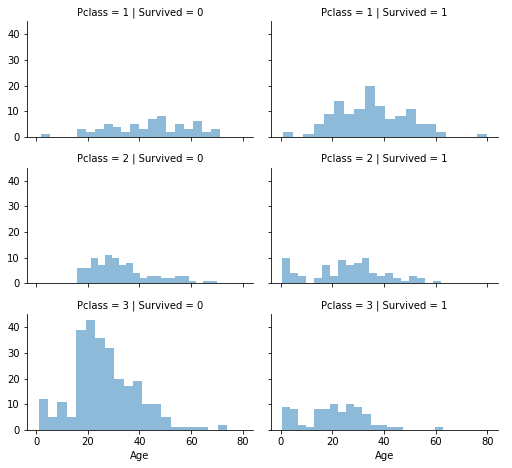

In [17]:
# Further anaysis shows same result. That people with class 1 survives more
grid = sn.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

Now SibSp and Parch is basically number of relatives on the ship so we can take it together.

In [18]:
data = [train_data,test_data]
for row in data:
    row['relatives'] = row['SibSp']+ row['Parch']
    row.loc[row['relatives']>0,'not_alone'] = 0
    row.loc[row['relatives'] == 0,'not_alone']=1
    row['not_alone'] = row['not_alone'].astype(int)
    
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

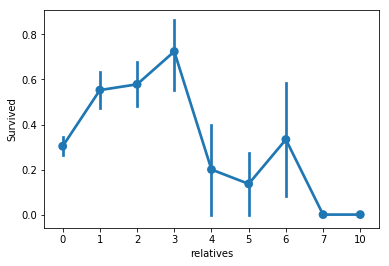

In [19]:
ax = sn.pointplot('relatives','Survived',data = train_data, aspect = 2.0)

We can see People having between 1-3 relatives has more survival rate. Suprisingly people with 6 relatives also have high rate of survival.

In [20]:
# DATA PROCESSING

First let us drop PassenerId as it is not important for survival.

In [21]:
train_data = train_data.drop(['PassengerId'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          714 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Cabin        204 non-null object
Embarked     889 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Cabin Number though is not important but it is in the form C897 so the first letter represents deck which can be extrated.

In [22]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data=[train_data,test_data]
for row in data:
    row['Cabin'] = row['Cabin'].fillna('z')
    row['Deck'] = row['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group()) # grouping all same alpha tog
    row['Deck']= row['Deck'].map(deck)
    row['Deck']= row['Deck'].fillna(0)
    row['Deck']=row['Deck'].astype(int)
    
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)


For Embarked we are putting common value in remainig 2 values.

In [23]:
train_data['Embarked'].describe() # top is the most common value

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [24]:
# common value is S which is inserted
common_value = 'S'
data = [train_data,test_data]
for row in data:
    row['Embarked']= row['Embarked'].fillna(common_value)

For age we are using mean value and standard deviations and number of null values to randomly fill values between the range

In [25]:
data = [train_data, test_data]
for row in data:
    mean = train_data['Age'].mean()
    std = test_data['Age'].std()
    null = row['Age'].isnull().sum()
    random_age = np.random.randint(mean - std, mean + std, size = null)
    age1 = row['Age'].copy() # convert nd array to a dictionary
    age1[np.isnan(age1)] = random_age
    row['Age'] = age1
    row['Age']= row['Age'].fillna(age1)
    row['Age']=row['Age'].astype(int)
    
train_data['Age'].isnull().sum()

0

Now we will normalise data so we are working with same type od data

In [26]:
# Making all the attrbutes of same data type
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


In [27]:
# First fare float to int.
data = [train_data, test_data]
for row in data:
    row ['Fare']= row['Fare'].fillna(0)
    row['Fare'] =  row['Fare'].astype(int)


In [28]:
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

In [29]:
# For Sex
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
train_data['Sex'] = number.fit_transform(train_data['Sex'].astype(str))
test_data['Sex'] = number.fit_transform(test_data['Sex'].astype(str))


In [30]:
# for embarked
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
train_data['Embarked'] = number.fit_transform(train_data['Embarked'].astype(str))
test_data['Embarked'] = number.fit_transform(test_data['Embarked'].astype(str))

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null int64
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null int64
Embarked     891 non-null int64
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: int64(11), object(1)
memory usage: 83.6+ KB


In [31]:
# dropping name which is not important factor
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'],axis =1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null int64
Embarked     891 non-null int64
relatives    891 non-null int64
not_alone    891 non-null int64
Deck         891 non-null int64
dtypes: int64(11)
memory usage: 76.6 KB


#  Now we will categorize the data.

In [32]:
# deviding age in catagories and conerting in numerical form
data = [train_data, test_data]
for row in data:
    row['Age'] = row['Age'].astype(int)
    row.loc[ row['Age'] <= 11, 'Age'] = 0
    row.loc[(row['Age'] > 11) & (row['Age'] <= 18), 'Age'] = 1
    row.loc[(row['Age'] > 18) & (row['Age'] <= 22), 'Age'] = 2
    row.loc[(row['Age'] > 22) & (row['Age'] <= 27), 'Age'] = 3
    row.loc[(row['Age'] > 27) & (row['Age'] <= 33), 'Age'] = 4
    row.loc[(row['Age'] > 33) & (row['Age'] <= 40), 'Age'] = 5
    row.loc[(row['Age'] > 40) & (row['Age'] <= 66), 'Age'] = 6
    row.loc[row['Age'] > 66, 'Age'] = 6

In [33]:
# A new feature age_class
data = [train_data, test_data]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [34]:
#new feature attribute per person
for row in data:
    row['Fare_Per_Person'] = row['Fare']/(row['relatives']+1)
    row['Fare_Per_Person'] = row['Fare_Per_Person'].astype(int)
train_data = train_data.drop(['Fare'],axis = 1)
test_data = test_data.drop(['Fare'],axis = 1)

In [35]:
# Building machine learning model
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
random_forest_score = round(random_forest.score(X_train, Y_train) * 100, 2)
random_forest_score

94.39

In [36]:
#  K-Fold Cross Validation 
from sklearn.model_selection import cross_val_score
r = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(r, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.73333333 0.82222222 0.78651685 0.85393258 0.86516854 0.84269663
 0.80898876 0.79775281 0.83146067 0.86363636]
Mean: 0.8205708773124503
Standard Deviation: 0.03871992994650783


In [37]:
# importance of different attributes
imp = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
imp = imp.sort_values('importance',ascending=False).set_index('feature')
imp.head(15)

,importance
feature,
Sex,0.294
Fare_Per_Person,0.200
Age_Class,0.101
Deck,0.082
Age,0.074
Pclass,0.064
relatives,0.056
Embarked,0.049
SibSp,0.040


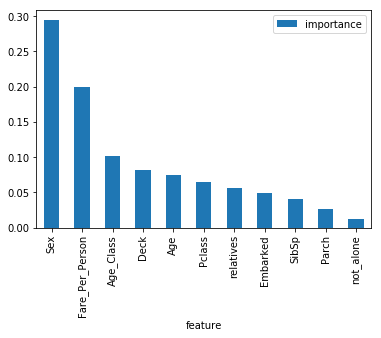

In [38]:
imp.plot.bar()

In [39]:
# dropping the attributes that has least importances

train_data  = train_data.drop("not_alone", axis=1)
test_data  = test_data.drop("not_alone", axis=1)

train_data = train_data.drop("Parch", axis=1)
test_data = test_data.drop("Parch", axis=1)

In [40]:
# finding the score after importance. It should be same that tells that these features were not that important and does not affect our model.
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

94.39 %


In [41]:
# oob score with 4 folds.
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 81.82000000000001 %


In [ ]:
# Hyperparameter tuning
para_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
r = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
cf = GridSearchCV(estimator=r, param_grid=para_grid, n_jobs=-1)
cf.fit(X_train, Y_train)
cf.best_params_


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [46]:
# Testing our model using gini index and finding the out of bag error score.
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train) 
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 81.93 %


In [47]:
# Now we weill use difference score methods to see the accuracy of our model

In [48]:
#confusion matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[480,  69],
       [ 95, 247]])

Here 69 and 95 are number of false positive and false negatives respectively.

In [49]:
# precision and recall
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.7816455696202531
Recall: 0.7222222222222222


This model shows 79% of time survival of a passenger correctly. Recall tells us how much percent of people it predicted that survived.

In [50]:
# fscore - Combining prediction and recall in one score.

from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.750759878419453

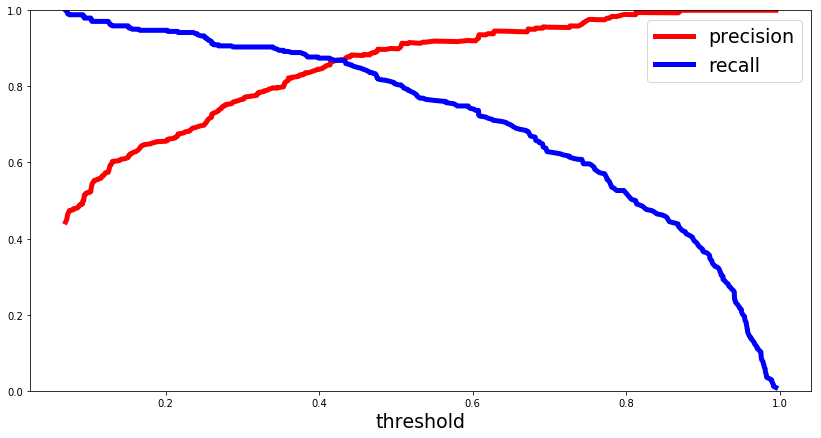

In [51]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

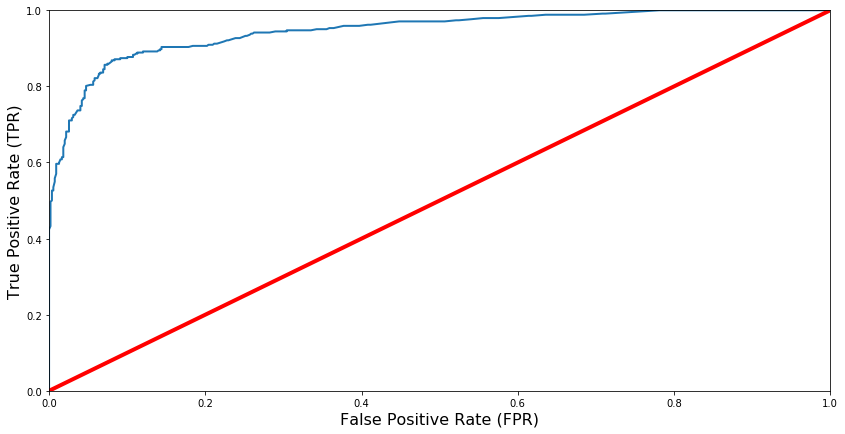

In [52]:
# ROC AUC curve
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [53]:
# ROC AUC score.
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9465109342877535


This is our score for prediction.